## <small>
Copyright (c) 2017-21 Andrew Glassner

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</small>



# Deep Learning: A Visual Approach
## by Andrew Glassner, https://glassner.com
### Order: https://nostarch.com/deep-learning-visual-approach
### GitHub: https://github.com/blueberrymusic
------

### What's in this notebook

This notebook is provided to help you work with Keras and TensorFlow. It accompanies the bonus chapters for my book. The code is in Python3, using the versions of libraries as of April 2021.

Note that I've included the output cells in this saved notebook, but Jupyter doesn't save the variables or data that were used to generate them. To recreate any cell's output, evaluate all the cells from the start up to that cell. A convenient way to experiment is to first choose "Restart & Run All" from the Kernel menu, so that everything's been defined and is up to date. Then you can experiment using the variables, data, functions, and other stuff defined in this notebook.


## Bonus Chapter 3 - Notebook 3: Keras with scikit-learn

In [1]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.constraints import maxnorm
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import h5py
import numpy as np

from keras import backend as keras_backend
keras_backend.set_image_data_format('channels_last')

Using TensorFlow backend.


In [2]:
# Workaround for Keras issues on Mac computers (you can comment this
# out if you're not on a Mac, or not having problems)
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
# Make a File_Helper for saving and loading files.

save_files = False

import os, sys, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.insert(0, os.path.dirname(current_dir)) # path to parent dir
from DLBasics_Utilities import File_Helper
file_helper = File_Helper(save_files)

In [4]:
random_seed = 42
np.random.seed(random_seed)

# load the MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
image_height = X_train.shape[1]
image_width = X_train.shape[2]
number_of_pixels = image_height * image_width

# cast the sample data to the current Keras floating-point type
X_train = keras_backend.cast_to_floatx(X_train)
X_test = keras_backend.cast_to_floatx(X_test)

# scale data to range [0, 1]
X_train /= 255.0
X_test /= 255.0

# save y_train and y_test when used with scikit-learn
original_y_train = y_train
original_y_test = y_test

# replace label data with one-hot encoded versions
number_of_classes = 1 + max(np.append(y_train, y_test))
y_train = np_utils.to_categorical(y_train, number_of_classes)
y_test = np_utils.to_categorical(y_test, number_of_classes)

# reshape to 2D grid, one line per image
X_train = X_train.reshape(X_train.shape[0], number_of_pixels)
X_test = X_test.reshape(X_test.shape[0], number_of_pixels)


In [5]:
# Build a network of any number of (dense+ dropout) layers of the given size
def make_model(number_of_layers=2, neurons_per_layer=32, dropout_ratio=0.2, optimizer='adam'):
    model = Sequential()

    # first layer is special, because it sets input_shape
    model.add(Dense(neurons_per_layer, input_shape=[number_of_pixels],
        activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(dropout_ratio))
    # now add in all the rest of the dense-dropout layers
    for i in range(number_of_layers-1):
        append_dense_dropout_layer(model, neurons_per_layer, dropout_ratio)
    # wrap up with a softmax layer with 10 outputs
    model.add(Dense(number_of_classes,  activation='softmax'))
    # compile the model and return it
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer, metrics=['accuracy'])
    return model

def append_dense_dropout_layer(model, neurons_per_layer, dropout_ratio):
    model.add(Dense(neurons_per_layer, 
        activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(dropout_ratio))

In [6]:
# create the KerasClassifier that packages up our model maker for CV and grid search
#
# Wrap up our model-making function into a KerasClassifier, which
# will make it behave like a standard scikit-learn estimator.  We'll
# give all the arguments defaults which we can override later when
# we build the model as part of cross-validation or grid search.
# For instance, we will provide a value to number_of_layers, so this
# value will be passed to number_of_layers when make_model() is called.
#

kc_model = KerasClassifier(build_fn=make_model,
                          number_of_layers=2, neurons_per_layer=32,
                          nb_epoch=100, batch_size=128, verbose=0)

In [7]:
def run_grid_search(param_grid, filename, verbose=2):
# Run the first grid search
    np.random.seed(random_seed)
    grid_searcher = GridSearchCV(estimator=pipeline, param_grid=param_grid, verbose=verbose)
    search_results = grid_searcher.fit(X_train, original_y_train)

    print('---- GRID SEARCH ----')
    print('mean test scores: {}\n'.format(search_results.cv_results_['mean_test_score']))
    best_index = np.argmax(search_results.cv_results_['mean_test_score'])
    print('best set of parameters:\n  index {}\n  {}\n'.format(best_index, 
                                                               search_results.cv_results_['params'][best_index]))

    params = search_results.cv_results_['params']
    dict_vals = [params[i].values() for i in range(len(params))]
    name_list =[[str(v) for v in dv] for dv in dict_vals]
    xlabels = ['-'.join(name_list[i]) for i in range(len(name_list))]
    plt.plot(search_results.cv_results_['mean_test_score'], 'r')
    plt.xticks(np.arange(len(xlabels)), xlabels, rotation='vertical')
    file_helper.save_figure(filename+'-mean-test-scores')
    plt.show()
    return search_results

In [8]:
# Run cross validation on our data, without a normalization step (that is, no pipeline)
np.random.seed(random_seed)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_seed)
cv_results1 = cross_val_score(kc_model, X_train, original_y_train, cv=kfold, verbose=2)
print("results1 ={}\nresults1.mean={}".format(cv_results1, cv_results1.mean()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   4.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s


[CV] END .................................................... total time=   3.8s
[CV] END .................................................... total time=   3.8s
[CV] END .................................................... total time=   3.9s
[CV] END .................................................... total time=   3.9s
[CV] END .................................................... total time=   3.9s
[CV] END .................................................... total time=   3.9s
[CV] END .................................................... total time=   4.0s
[CV] END .................................................... total time=   3.9s
[CV] END .................................................... total time=   4.1s
results1 =[0.91133332 0.91299999 0.91883332 0.91383332 0.90883332 0.91016668
 0.91533333 0.91033334 0.9145     0.90883332]
results1.mean=0.9124999940395355


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   39.4s finished


In [9]:
# Run a CV step with a pipeline
np.random.seed(random_seed)
pipeline = make_pipeline(MinMaxScaler(), kc_model)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_seed)
cv_results2 = cross_val_score(pipeline, X_train, original_y_train, cv=kfold, verbose=2)
print("results2 ={}\nresults2.mean={}".format(cv_results2, cv_results2.mean()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   4.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s


[CV] END .................................................... total time=   4.4s
[CV] END .................................................... total time=   4.4s
[CV] END .................................................... total time=   4.5s
[CV] END .................................................... total time=   4.7s
[CV] END .................................................... total time=   4.5s
[CV] END .................................................... total time=   4.7s
[CV] END .................................................... total time=   4.4s
[CV] END .................................................... total time=   4.5s
[CV] END .................................................... total time=   4.8s
results2 =[0.91366667 0.92116666 0.9145     0.91616666 0.91083336 0.90933335
 0.91983336 0.90783334 0.90866667 0.91166669]
results2.mean=0.9133666753768921


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   45.5s finished


Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END model_step__neurons_per_layer=20, model_step__number_of_layers=2, model_step__optimizer=adam; total time=   4.2s
[CV] END model_step__neurons_per_layer=20, model_step__number_of_layers=2, model_step__optimizer=adam; total time=   4.2s
[CV] END model_step__neurons_per_layer=20, model_step__number_of_layers=2, model_step__optimizer=adam; total time=   4.4s
[CV] END model_step__neurons_per_layer=20, model_step__number_of_layers=2, model_step__optimizer=adam; total time=   4.1s
[CV] END model_step__neurons_per_layer=20, model_step__number_of_layers=2, model_step__optimizer=adam; total time=   4.1s
[CV] END model_step__neurons_per_layer=20, model_step__number_of_layers=2, model_step__optimizer=adadelta; total time=   4.3s
[CV] END model_step__neurons_per_layer=20, model_step__number_of_layers=2, model_step__optimizer=adadelta; total time=   4.7s
[CV] END model_step__neurons_per_layer=20, model_step__number_of_layers=2, mo

[CV] END model_step__neurons_per_layer=40, model_step__number_of_layers=2, model_step__optimizer=adadelta; total time=   7.2s
[CV] END model_step__neurons_per_layer=40, model_step__number_of_layers=2, model_step__optimizer=adadelta; total time=   9.0s
[CV] END model_step__neurons_per_layer=40, model_step__number_of_layers=2, model_step__optimizer=adadelta; total time=   7.2s
[CV] END model_step__neurons_per_layer=40, model_step__number_of_layers=2, model_step__optimizer=adadelta; total time=   7.3s
[CV] END model_step__neurons_per_layer=40, model_step__number_of_layers=3, model_step__optimizer=adam; total time=   9.8s
[CV] END model_step__neurons_per_layer=40, model_step__number_of_layers=3, model_step__optimizer=adam; total time=   9.8s
[CV] END model_step__neurons_per_layer=40, model_step__number_of_layers=3, model_step__optimizer=adam; total time=  10.2s
[CV] END model_step__neurons_per_layer=40, model_step__number_of_layers=3, model_step__optimizer=adam; total time=  10.1s
[CV] END

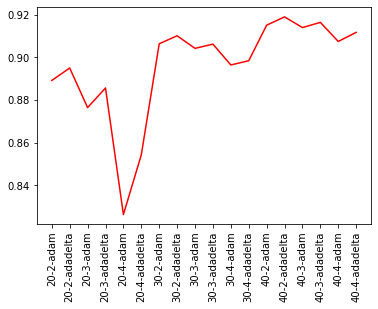

In [10]:
# build a long-form, named pipeline for grid search steps
estimators = []
estimators.append(('normalize_step', MinMaxScaler()))
estimators.append(('model_step', kc_model))
pipeline = Pipeline(estimators)

# Run the first grid search
param_grid1 = dict(model_step__number_of_layers=[ 2, 3, 4 ],
                   model_step__neurons_per_layer=[ 20, 30, 40 ],
                   model_step__optimizer=[ 'adam', 'adadelta' ]) 
search_results1 = run_grid_search(param_grid1, 'GridSearch1')

In [11]:
search_results1.cv_results_['mean_test_score']

array([0.88921666, 0.89505   , 0.87648333, 0.88568333, 0.8263    ,
       0.85435001, 0.90643332, 0.91016668, 0.90426666, 0.90625   ,
       0.89648333, 0.89846667, 0.91513333, 0.91905   , 0.91403334,
       0.91646667, 0.90751665, 0.91176666])

In [12]:
best_index1 = np.argmax(search_results1.cv_results_['mean_test_score'])
print('best set of parameters:\n  index {}\n  {}\n'.format(
              best_index1, search_results1.cv_results_['params'][best_index1]))

best set of parameters:
  index 13
  {'model_step__neurons_per_layer': 40, 'model_step__number_of_layers': 2, 'model_step__optimizer': 'adadelta'}



Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END model_step__neurons_per_layer=50, model_step__number_of_layers=1; total time=   5.6s
[CV] END model_step__neurons_per_layer=50, model_step__number_of_layers=1; total time=   5.6s
[CV] END model_step__neurons_per_layer=50, model_step__number_of_layers=1; total time=   5.7s
[CV] END model_step__neurons_per_layer=50, model_step__number_of_layers=1; total time=   7.3s
[CV] END model_step__neurons_per_layer=50, model_step__number_of_layers=1; total time=   6.4s
[CV] END model_step__neurons_per_layer=50, model_step__number_of_layers=2; total time=   9.2s
[CV] END model_step__neurons_per_layer=50, model_step__number_of_layers=2; total time=   9.2s
[CV] END model_step__neurons_per_layer=50, model_step__number_of_layers=2; total time=   8.8s
[CV] END model_step__neurons_per_layer=50, model_step__number_of_layers=2; total time=   8.8s
[CV] END model_step__neurons_per_layer=50, model_step__number_of_layers=2; total time=   8.9s

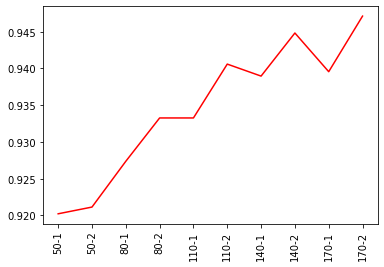

In [13]:
param_grid2 = dict(model_step__number_of_layers=[ 1, 2],
                  model_step__neurons_per_layer=[ 50, 80, 110, 140, 170 ]) 
search_results2 = run_grid_search(param_grid2, 'GridSearch2')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END model_step__neurons_per_layer=180, model_step__number_of_layers=1; total time=   7.4s
[CV] END model_step__neurons_per_layer=180, model_step__number_of_layers=1; total time=   7.5s
[CV] END model_step__neurons_per_layer=180, model_step__number_of_layers=1; total time=   7.5s
[CV] END model_step__neurons_per_layer=180, model_step__number_of_layers=1; total time=   7.8s
[CV] END model_step__neurons_per_layer=180, model_step__number_of_layers=1; total time=   7.5s
[CV] END model_step__neurons_per_layer=180, model_step__number_of_layers=2; total time=  11.8s
[CV] END model_step__neurons_per_layer=180, model_step__number_of_layers=2; total time=  10.8s
[CV] END model_step__neurons_per_layer=180, model_step__number_of_layers=2; total time=  15.4s
[CV] END model_step__neurons_per_layer=180, model_step__number_of_layers=2; total time=  10.7s
[CV] END model_step__neurons_per_layer=180, model_step__number_of_layers=2; total ti

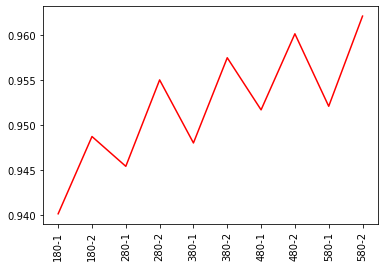

In [14]:
param_grid3 = dict(model_step__number_of_layers=[ 1, 2],
                  model_step__neurons_per_layer=[ 180, 280, 380, 480, 580 ]) 
search_results3 = run_grid_search(param_grid3, 'GridSearch3')